# Predicting Acceptance of US Visa Applications Using Machine Learning
Capstone Project for SlideRule Intensive Data Science workshop.

Charles Franzen

## The Project

Each year hundreds of thousands of applications are filed for work visas in the US. So many, in fact, that legistated caps on the number of H-1B applications have been reached every single year since 2007. In 2008, the quota was reached on the first day of open applications. In light of this, companies and potential employees that are lucky enough to get their application in via the lottery want to ensure that they have as high a chance as possible of having their application approved.

This project investigates application data sets and create models that predict the risk of rejection of a new application. These models can evaluate the strength of an application before it is submitted, and provide insights into how a weak application can be improved. The models also elucidate the most important factors determining the fate of a visa application.

## The Data

The data are published by the US Dapartment of Labor. The data sets are comprised of quarterly application data and decisions for different types of visas in 2015. The data (72 MB) is found at:

        http://www.foreignlaborcert.doleta.gov/docs/py2015q4/PERM_Disclosure_Data_FY15_Q4.xlsx
        
With the record layout at:

        http://www.foreignlaborcert.doleta.gov/docs/py2015q4/PERM_FY15_Record_Layout.doc

The data fields cover a wide range of information, including details about the country of origin of the applicant, location and type of the job, pay and educational requirements of the job, education of the applicant, and whether all regulatory hurdles have been cleared.

H-1B visas are work visas that are only for 'specialty applications', and therefore can act as a bellweather for how much highly-educated talent the US is importing.

## Methodology

I have treated this as a supervised learning classification problem. The binary variable 'denied' indicates whether an application was rejected.

### Libraries

pandas for:

        data loading, wrangling, cleaning, and manipulation
        feature selection and engineering
        descriptive statistics

numpy for:

        array data structure, the primary input for classifiers
        model comparison
        matrix manipulation

patsy for:

        dummy variable creation
        array formatting for classifiers
        
scikit-learn for:

        classifier models
        parameter gridsearch
        model evaluation
        
matplotlib for:
        
        data visualization
        
### Data Wrangling and Cleaning

The data come in the form of MS Excel spreadsheets, which are easily loaded into pandas dataframes. All the data are formatted as unicode strings, some of which pandas handles automatically. For example, the submission dates are automatically read as pandas date-time objects. Some strings require a little more work to prepare them for the classifiers. Yes/No fields are converted in to binary integers, and commas are removed from numerical data before converting them to floats. To deal with categorical data, dummy variables are created for each category using a patsy formula. NaNs are handled by filling in a 0, since I prefer that a feature is underweighted due to extra zeros, rather than overweighted due to extra ones.

### Feature Selection and Engineering

Since the data set is large, I've included as many features as possible, since I do not want to rely on intuition or fuzzy logic to build the model. Including as much information as possible increases the chances of unveiling a new or surprising insight. To capture seasonal variations, the month of each application submission was extracted and treated as a categorical variable. In order to gauge the effect of higher or lower than normal salary offers, A feature was created to identify offers with a significantly higher or lower salary than the prevailing wage for the job.

### Model Fitting

Models were fit using GridSearchCV, which searches through a grid of parameters for each model, returning the model that gives the highest k-fold cross validation score.

#### Logistic Regression (Logit)

Logistic regression is usefull in that it returns coefficients for each feature, which might be positive or negative, giving an indication of whether a particular feature is weakening or strengthening an application. This is in contrast to decision tree-based models, which only report 'feature importance'.

Scikit Learn does not provide a method for adjusting the threshold probability for classification (default is .5), so this had to be adjusted manually. This was repeated for all other classifiers.

#### Decision Tree Classification (DTC)

Once the data is formatted for Logistic Regression, it is easy to fit a decision tree and, indeed, all the other classifiers. Decision Trees are somewhat computationaly expensive, so the number of parameter combinations that can be tested is limited.

#### Random Forest  (RF)

This ensemble method pairs well with Decisions Trees, as it creates random trees and evaluates them. This is a good way to check many different trees, as opposed to DTC. As it creates and compares 10 different trees every time it's called, RF gets very expensive, so cross-validation was limited to 5-fold.

#### Gradient Boosting Classifier (GBC)

This ensemble method creates a strong learner out of many weak learners (trees in this case). It begins with a base model, then iteratively adjusts it, stepping down the cost-function gradient. A modification of the model fits the base tree to a random sample of the training set. This is called Stochastic Gradient Boosting, and was identified by grid search as a more accurate model. Gradient Boosting is also very expensive, so parameter optimization was limited.

#### Voting Classifier (Vote)

In order to summarize the combined wisdom of the different models, a voting classifier is used, identifying the riskiest applications by consensus.

### Model Evaluation

Accuracy does not turn out to be a very useful way of evaluating the models. Instead, precision and recall are much more important. The goal is to find a model that flags at least half of all rejected applications, and for the flagged applications to be at as high a risk as possible of being rejected. This way, if an application is flagged, it will be known that it at much higher than average risk of being rejected, and a decision can be made accordingly.

To do the evaluation, I used confusion matrices to analyze precision and recall for each model. I also tuned the probability at which an application was flagged risky, using binary search in most cases, and linear search in the one case (DCT) where this did not work.

I also did a final k-fold cross-validation to ensure that there were not wild variations in accuracy across different data samples, which might indicate overfitting to training data.

## Results

The selected models were very effective in searching out risky applications. The null hypothesis is for this problem is the risk that an application will be rejected if no applications are flagged as risky, which is about 7%.

$ H_{null}=.067$

For every model, flagged applications were at a much greater risk of rejection:

    Model        Risk
    
    Logit        .18
    DTC          .34
    RF           .31
    GBC          .23
    Vote         .24
        

All of the coefficients and feature importances are listed below, but the primary trend is that highly-paid specialists are at the lowest risk of being rejected. Positions requiring little or no education, or with low wages and, especially, wages below the prevailing wage for the industry are rejected at high rates. Applications prepared in house by the sponsoring company are also at an advantage. H-1B visas are rejected at a lower rate than other visa types.

A less prominent narrative concerns the opportunity to exploit foreign workers: jobs that require the worker to live at the work site and live in domestic workers are rejected at a higher-than-normal rate. In jobs like these, the worker is at considerable risk of exploitation at the hands of their employer, so this may be a measure to prevent human trafficking or labor abuses.

There are geographical and seasonal patterns. Indians have a low rate of rejection, and Mexicans a high one, and March is the best month to turn in a application, but these variables are of dubious causal significance.

## Limitations

Since the base rate of application rejection is so low (6.7% for all visa types), it is difficult to suss out relevant variables. The models tended to have a high number of false-negatives (type II errors).

The models also end up provinding some unhelpful insights. For example, country of citizenship is a strong factor in application acceptance. It won't be helpful to most applicants to tell them to change their citizenship.

## Further Research

All of the important features can be examined for further correlations/patterns. Some features seem likely candidates for dimensionality reduction through PCA, like the three wage features.

Risk assessment for specific visa types could be carried out using these same techniques. H-1B is the likely candidate.

The project could be wrapped in a web application and tested on real world data, asking visa applicants to input their info and report back their results, which could be compared to the model's prediction. When new quarterly data are published, the model's predictive capabilities can be tested in earnest.

This projects also acts as a proof-of-concept for application analysis. It could easily be applied to other types of applications for which large data sets exist.

## Client Recommendations

To minimize the risk of a costly rejection, companies should screen foreign applicants and choose the best qualified, with the lowest chances of rejection. Screened applicants should then have their applications prepared either in house or by an immigration professional (most likely a lawyer).

If all available candidates are risky, the company should look at the application features that are most significantly increasing risk and alter the application and their job offer to reduce risk. Common recommendations will be to apply for H-1B visas and increase the wage being offered. 

# Code

## Import Modules

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split,  cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# setting matplotlib style
plt.style.use('fivethirtyeight')

## Data Loading and Initial Processing
Withdrawn applications are removed from the data set, since there was no decision made.

In [3]:
# loading data
data = pd.read_excel('Data/PERM_Disclosure_Data_FY15_Q4.xlsx', 'DDFY2015_Final')

# removing withdrawn applications
data = data[data['CASE_STATUS'] != 'Withdrawn']

# adding a binary series with 1 indicating that an application was denied
data['denied'] = (data.CASE_STATUS == 'Denied').astype(int)

In [4]:
# converting dates into months
data['month'] = data.DECISION_DATE.dt.month

## Descriptive Statistics

In [5]:
status = data['CASE_STATUS'].value_counts()
status

Certified            40176
Certified-Expired    38762
Denied                5696
Name: CASE_STATUS, dtype: int64

In [6]:
pcert, pcertex, pdenied = (data['CASE_STATUS'].value_counts().values) / float(len(data))
size = len(data)
print 'Certified: \t\t', pcert, '\nCertified-Expired: \t', pcertex, '\nDenied: \t\t', pdenied, '\nSize: \t\t\t', size
                                                                 

Certified: 		0.474702838103 
Certified-Expired: 	0.457995604603 
Denied: 		0.0673015572938 
Size: 			84634


([<matplotlib.patches.Wedge at 0x1167494d0>,
  <matplotlib.text.Text at 0x116c92b90>])

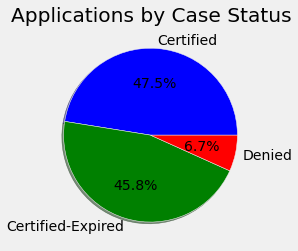

In [78]:
labels = list(status.index)
plt.figure(figsize=[8, 8])
fracs = pcert, pcertex, pdenied
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Case Status')
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)

Base rate of denials is low, at 6.7%, and many accepted applications are allowed to expire.

In [51]:
serror = (pdenied*(1-pdenied)/float(len(data))) ** .5
print 'Standard Error: ',serror

Standard Error:  0.000861213341343


### Categorical Data

In [52]:
# possibly interesting columns of categorical data
dfcat = data[['denied', 'EMPLOYER_NAME', 'EMPLOYER_STATE', 'AGENT_FIRM_NAME', 'PW_SOC_TITLE', 'JOB_INFO_EDUCATION', 
              'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION', 
              'FOREIGN_WORKER_INFO_MAJOR']]

After exploring the columns, Visa Type, Country of Citizenship, and Education seem to be the most interesting columns.

In [53]:
# visa types with a high rate of denial
dftype = dfcat[['CLASS_OF_ADMISSION', 'denied']]
dftype1 = dftype.groupby('CLASS_OF_ADMISSION').mean()
dftype1['size'] = dftype.groupby('CLASS_OF_ADMISSION').agg(sum)
dftype = dftype1[(dftype1['denied'] > (pdenied + 2*serror)) & (dftype1['size'] >= 10)]
dftype.head()

,denied,size
CLASS_OF_ADMISSION,,
B-1,0.347826,40
B-2,0.265248,187
E-1,0.149123,17
E-2,0.123584,120
E-3,0.071429,11


In [54]:
visa_types = dfcat.groupby('CLASS_OF_ADMISSION').count()['denied']
visa_types = visa_types.sort_values()[:-5:-1]
visa_types

CLASS_OF_ADMISSION
H-1B          64729
L-1            5136
F-1            3163
Not in USA     1554
Name: denied, dtype: int64

In [55]:
# countries with a high rate of denial
dfcit = dfcat[['COUNTRY_OF_CITIZENSHIP', 'denied']]
dfcit1 = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').mean()
dfcit1['size'] = dfcit.groupby('COUNTRY_OF_CITIZENSHIP').agg(sum)
dfcit = dfcit1[(dfcit1['denied'] > (pdenied + 2*serror)) & (dfcit1['size'] >= 10)]
dfcit.sort_values('denied')[::-1].head()

,denied,size
COUNTRY_OF_CITIZENSHIP,,
GAMBIA,0.850000,17
SLOVAKIA,0.400000,12
GUATEMALA,0.303371,27
ECUADOR,0.270408,53
EL SALVADOR,0.237624,24


In [56]:
countries = dfcat.groupby('COUNTRY_OF_CITIZENSHIP').count()['denied']
countries = countries.sort_values()[::-1][:5]
countries['ALL_OTHERS'] = 19427
countries

COUNTRY_OF_CITIZENSHIP
INDIA          47705
CHINA           6843
SOUTH KOREA     5645
CANADA          3139
PHILIPPINES     1875
ALL_OTHERS     19427
Name: denied, dtype: int64

([<matplotlib.patches.Wedge at 0x118a2fed0>,
  <matplotlib.text.Text at 0x118dd5e90>])

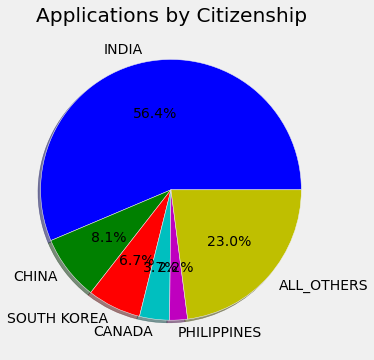

In [84]:
country_labels = list(countries.index)
country_fracs = countries.values
plt.figure(figsize=[12, 12])
plt.subplot(the_grid[1, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

In [58]:
dfcat.groupby(['FOREIGN_WORKER_INFO_EDUCATION'])['denied'].mean().sort_values()

FOREIGN_WORKER_INFO_EDUCATION
Doctorate      0.033010
Master's       0.051275
Bachelor's     0.053348
Other          0.074332
Associate's    0.185270
None           0.228803
High School    0.270021
Name: denied, dtype: float64

In [59]:
education = dfcat.groupby('FOREIGN_WORKER_INFO_EDUCATION').count()['denied'].sort_values()[::-1]
education

FOREIGN_WORKER_INFO_EDUCATION
Master's       38245
Bachelor's     30910
None            4812
Doctorate       4635
Other           3740
High School     1411
Associate's      869
Name: denied, dtype: int64

([<matplotlib.patches.Wedge at 0x1265f1250>,
  <matplotlib.text.Text at 0x1263f63d0>])

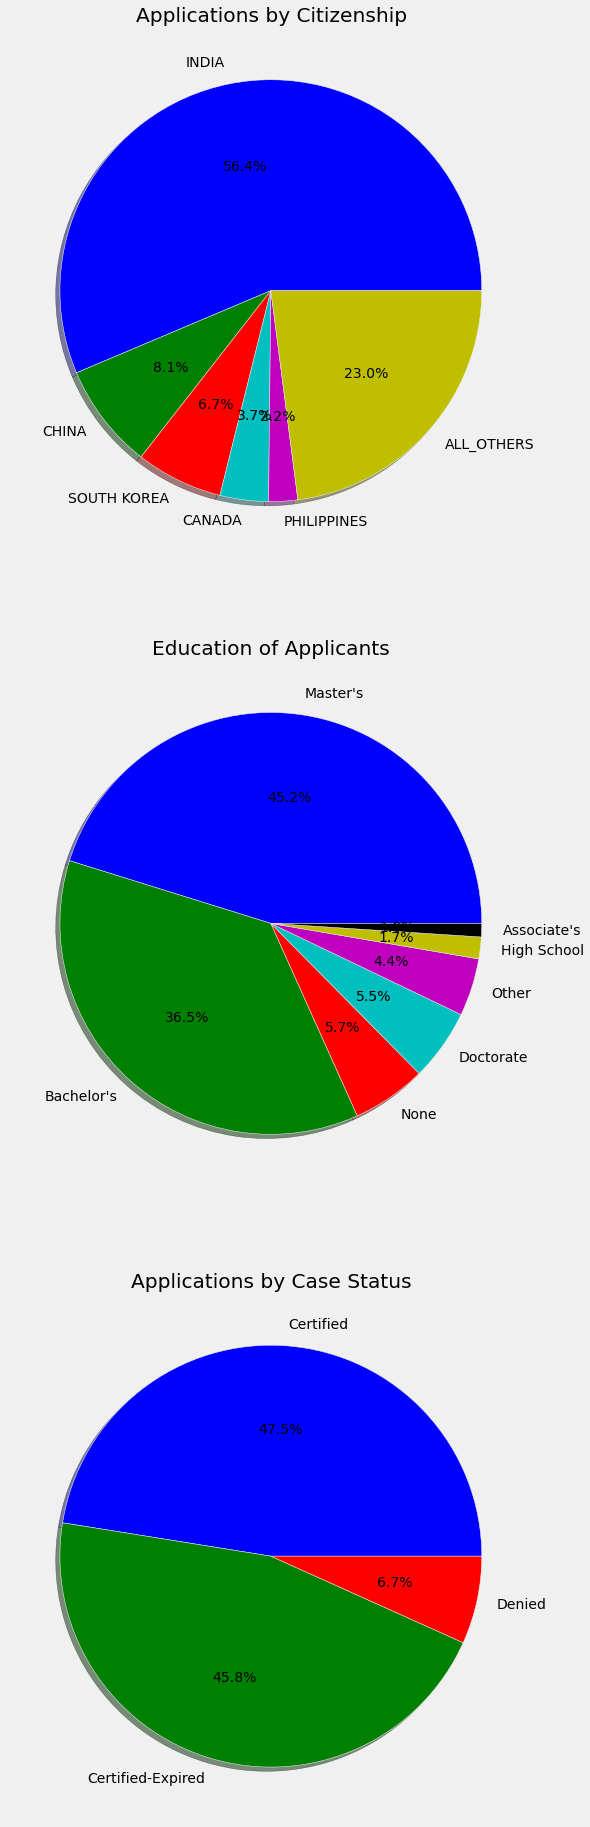

In [94]:
status_labels = list(status.index)
status_fracs = pcert, pcertex, pdenied
plt.figure(figsize=[30, 30])
the_grid = GridSpec(3, 1)
plt.subplot(the_grid[2, 0], aspect=1, title='Applications by Case Status')
plt.pie(status_fracs, labels=status_labels, autopct='%1.1f%%', shadow=True)

country_labels = list(countries.index)
country_fracs = countries.values
plt.subplot(the_grid[0, 0], aspect=1, title='Applications by Citizenship')
plt.pie(country_fracs, labels=country_labels, autopct='%1.1f%%', shadow=True)

ed_labels = list(education.index)
ed_fracs = education.values
plt.subplot(the_grid[1, 0], aspect=1, title='Education of Applicants')
plt.pie(ed_fracs, labels=ed_labels, autopct='%1.1f%%', shadow=True)

In [61]:
dfcat.groupby(['JOB_INFO_EDUCATION'])['denied'].mean().sort_values()

JOB_INFO_EDUCATION
Doctorate      0.025573
Master's       0.047168
Bachelor's     0.051324
Other          0.075218
Associate's    0.188406
None           0.233772
High School    0.304193
Name: denied, dtype: float64

Applicants with at least a Bachelor's have significantly lower rates of rejection than those without one.

## Data Preparation for Logistic Regression

All of the data are given as unicode, even the numbers, so it has to be converted into the proper data type before the regression can be run. Additionally, dummy variables need to be created for the categorical data.

In [78]:
# interesting fields with binary or numerical data
data_fields = ['REFILE', 'EMPLOYER_NUM_EMPLOYEES', 
               'FOREIGN_WORKER_OWNERSHIP_INTEREST', 'PW_AMOUNT_9089', 'WAGE_OFFER_FROM_9089', 'WAGE_OFFER_TO_9089', 
               'JOB_INFO_TRAINING', 'JOB_INFO_TRAINING_NUM_MONTHS', 'JOB_INFO_EXPERIENCE', 
               'JOB_INFO_EXPERIENCE_NUM_MONTHS', 'JOB_INFO_ALT_FIELD', 'JOB_INFO_ALT_COMBO_ED_EXP', 
               'JOB_INFO_ALT_CMB_ED_OTH_YRS', 'JOB_INFO_FOREIGN_ED', 'JOB_INFO_ALT_OCC', 'JOB_INFO_ALT_OCC_NUM_MONTHS', 
               'JOB_INFO_JOB_REQ_NORMAL', 'JOB_INFO_FOREIGN_LANG_REQ', 'JOB_INFO_COMBO_OCCUPATION',
               'JI_FOREIGN_WORKER_LIVE_ON_PREMISES', 'JI_LIVE_IN_DOMESTIC_SERVICE', 'JI_LIVE_IN_DOM_SVC_CONTRACT', 
               'RECR_INFO_PROFESSIONAL_OCC', 'RECR_INFO_COLL_UNIV_TEACHER', 'RECR_INFO_COLL_TEACH_COMP_PROC', 
               'RI_POSTED_NOTICE_AT_WORKSITE', 'RI_LAYOFF_IN_PAST_SIX_MONTHS', 'RI_US_WORKERS_CONSIDERED', 
               'FOREIGN_WORKER_INFO_TRAINING_COMP', 'FOREIGN_WORKER_INFO_REQ_EXPERIENCE', 
               'FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE', 'FOREIGN_WORKER_INFO_REL_OCCUP_EXP', 
               'PREPARER_INFO_EMP_COMPLETED']
dflogit = data[data_fields]

In [79]:
dflogit.head()

,REFILE,EMPLOYER_NUM_EMPLOYEES,FOREIGN_WORKER_OWNERSHIP_INTEREST,PW_AMOUNT_9089,WAGE_OFFER_FROM_9089,WAGE_OFFER_TO_9089,JOB_INFO_TRAINING,JOB_INFO_TRAINING_NUM_MONTHS,JOB_INFO_EXPERIENCE,JOB_INFO_EXPERIENCE_NUM_MONTHS,...,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_COLL_TEACH_COMP_PROC,RI_POSTED_NOTICE_AT_WORKSITE,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_US_WORKERS_CONSIDERED,FOREIGN_WORKER_INFO_TRAINING_COMP,FOREIGN_WORKER_INFO_REQ_EXPERIENCE,FOREIGN_WORKER_INFO_ALT_EDU_EXPERIENCE,FOREIGN_WORKER_INFO_REL_OCCUP_EXP,PREPARER_INFO_EMP_COMPLETED
0,N,1935,N,"83,366.00","90,000.00","95,000.00",N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,Y,N
1,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
2,N,4,N,"49,982.00","65,000.00",NaN,N,NaN,Y,36,...,N,NaN,Y,N,NaN,A,Y,A,A,N
3,N,8,N,"43,514.00","43,514.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N
4,N,350,N,"16,973.00","16,973.00",NaN,N,NaN,N,NaN,...,N,NaN,Y,N,NaN,A,A,A,A,N


The data cleaning ended up being a little tricky, as some columns were initially dropped without me noticing. The cleaning operation converts unicode numbers into floats and Y/N indicators into binary.

In [80]:
def remove_commas(uni):
    # converts unicode numbers with commas into floats
    string = str(uni)
    if ',' in string:
        return float(string.replace(',', ''))
    elif '#' in string:
        return 0

def data_clean(df):
    # formats datatypes to binary for indicators or floats for numbers
    columns = df.columns
    dfr = pd.DataFrame()
    for column in columns:
        name = str(column)
        name = name.lower()
        if str(df[column][1]) in ['Y', 'N']:
            dfr[name] = (df[column] == 'Y').astype(int)
        else:
            try:
                dfr[name] = df[column].apply(str).apply(remove_commas)
            except ValueError:
                continue
    return dfr

def add_columns(df1, df2, columns):
    # adds columns from one dataframe to another
    for column in columns:
        df2[column] = df1[column]

In [81]:
dflogit = data_clean(dflogit)

In [82]:
# adding prevailing wage comparison features
dflogit['lowball'] = (dflogit['pw_amount_9089'] > dflogit['wage_offer_from_9089']).apply(int)
dflogit['highoffer'] = (dflogit['pw_amount_9089'] < dflogit['wage_offer_to_9089']).apply(int)

I thought that perhaps the how the wage offered to the immigrant worker compared to the prevailing wage of the profession might affect rejection, so I added two feature to identify lowball and higher-than-normal offers.

In [83]:
# formatting data for logistic regression

new_columns = ['month', 'JOB_INFO_EDUCATION', 'COUNTRY_OF_CITIZENSHIP', 'CLASS_OF_ADMISSION', 'FOREIGN_WORKER_INFO_EDUCATION',
               'denied']
add_columns(data, dflogit, new_columns)

Missing data is replaced with a 0, since classifiers cannot handle NaNs. setting the default to 0 will minimize the distortion.

In [84]:
# dealing with missing data
dflogit = dflogit.fillna(0)

In [85]:
dflogit.head()

,refile,employer_num_employees,foreign_worker_ownership_interest,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089,job_info_training,job_info_training_num_months,job_info_experience,job_info_experience_num_months,...,foreign_worker_info_rel_occup_exp,preparer_info_emp_completed,lowball,highoffer,month,JOB_INFO_EDUCATION,COUNTRY_OF_CITIZENSHIP,CLASS_OF_ADMISSION,FOREIGN_WORKER_INFO_EDUCATION,denied
0,0,0,0,83366,90000,95000,0,0,0,0,...,0,0,0,1,5,Bachelor's,INDIA,H-1B,Bachelor's,0
1,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,6,None,SOUTH KOREA,0,None,1
2,0,0,0,49982,65000,0,0,0,1,0,...,0,0,0,0,10,Doctorate,GERMANY,H-1B,Doctorate,1
3,0,0,0,43514,43514,0,0,0,0,0,...,0,0,0,0,5,Master's,SOUTH KOREA,E-2,Master's,0
4,0,0,0,16973,16973,0,0,0,0,0,...,0,0,0,0,6,None,SOUTH KOREA,0,None,1


In [86]:
# checking that no columns or data points were dropped
print 'n: ', len(dflogit)
print 'features: ', len(dflogit.columns)

# checking data types
dflogit.dtypes

n:  84634
features:  41


refile                                      int64
employer_num_employees                      int64
foreign_worker_ownership_interest           int64
pw_amount_9089                            float64
wage_offer_from_9089                      float64
wage_offer_to_9089                        float64
job_info_training                           int64
job_info_training_num_months                int64
job_info_experience                         int64
job_info_experience_num_months              int64
job_info_alt_field                          int64
job_info_alt_combo_ed_exp                   int64
job_info_alt_cmb_ed_oth_yrs                 int64
job_info_foreign_ed                         int64
job_info_alt_occ                            int64
job_info_alt_occ_num_months                 int64
job_info_job_req_normal                     int64
job_info_foreign_lang_req                   int64
job_info_combo_occupation                   int64
ji_foreign_worker_live_on_premises          int64


In [87]:
wages = dflogit[['pw_amount_9089', 'wage_offer_from_9089', 'wage_offer_to_9089']].replace('0', np.nan)
wages.describe()

,pw_amount_9089,wage_offer_from_9089,wage_offer_to_9089
count,82951.000000,82247.000000,22451.000000
mean,85402.096103,93688.169319,127946.312091
std,38569.882008,39830.833135,44435.788980
min,1067.200000,1060.000000,1000.000000
25%,67808.000000,72467.000000,102200.000000
50%,84802.000000,90459.000000,127300.000000
75%,103938.000000,110410.000000,148400.000000
max,5067600.000000,1145000.000000,1347000.000000


<IPython.core.display.Javascript object>


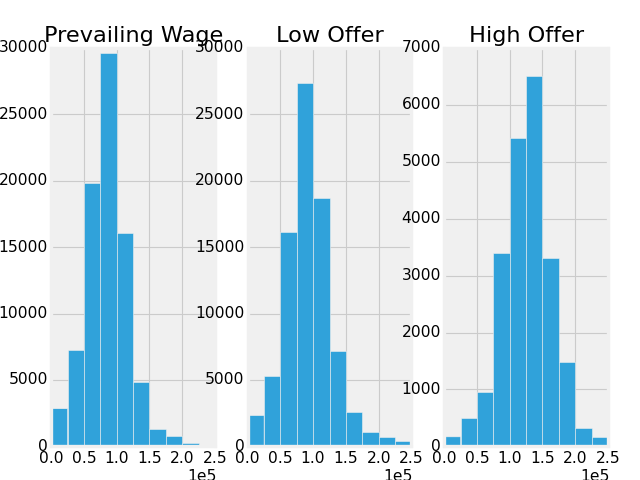

In [88]:
# histograms of wage data
fig, ax = plt.subplots(ncols=3)
index = 0
titles = ['Prevailing Wage', 'Low Offer', 'High Offer']
for column in wages.columns:
    column = str(column)
    ax[index].hist(wages[column].values, range=(0, 250000))
    ax[index].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[index].set_title(titles[index])
    index += 1

In [91]:
# creating a formula for dmatrices, including dummy variables
params = dflogit.columns[:-6]
dummies = ['C(month)', 'C(JOB_INFO_EDUCATION)', 'C(COUNTRY_OF_CITIZENSHIP)', 'C(CLASS_OF_ADMISSION)', 'C(FOREIGN_WORKER_INFO_EDUCATION)']
f = 'denied ~ ' + ' + '.join(params) + ' + ' + ' + '.join(dummies)

In [92]:
# convert pandas dataframe into numpy arrays for sklearn logit
y, X = dmatrices(f, dflogit, NA_action='raise', return_type="dataframe")

# checking to see that none of the data points were lost
print 'n: ', len(y)
print 'features: ', len(X.columns)

n:  84634
features:  289


There are about 300x as many data points as features.

In [93]:
# flattening y into a 1-D array
y = np.ravel(y)

# splitting data in to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

## Logistic Regression

Using grid search and cross validation, a model is fit to the training set.

In [94]:
%%time
logit_params = {'C': [.01, .1, 1., 10., 100.]}
logit = LogisticRegression(class_weight='balanced')
lgt = GridSearchCV(logit, logit_params, cv=10)
lgt.fit(X_train, y_train)

CPU times: user 1min 7s, sys: 3.62 s, total: 1min 11s
Wall time: 1min 11s


The null hypothesis for this model is to simply guess that all applications will be accepted. As will be shown, though, comparing the accuracy of the model and the null hypothesis is not an adequate way of evaluating the model.

In [191]:
# model accuracy
print 'Acc: ', lgt.score(X_test, y_test)

# null hypotheses
null_risk = y_test.mean()
null = null_risk

print 'Null: ', null

Acc:  0.68809073724
Null:  0.0645085066163


At first glance, the model is doing worse than the null (accepting every application).

### Evaluating the Model

The default decision point for logistic regression is .5, but this can be adjusted manually to further optimize the model. My goals are to maximize recall and precision for rejected applications.

In [281]:
def decision_threshold(clf, X, cutoff=.5):
    ''' Adjusts the decision cutoff for sklearn classifier predictions
    
    Parameters: 
    clf -- an sklearn classifier object
    X -- a numpy array of unlabeled data
    cutoff --  a float between 0 and 1
    
    Returns:
    a numpy array of binary predictions
    '''
    probs = clf.predict_proba(X)
    count = []
    for prob in probs:
        if prob[1] > cutoff:
            count.append(1)
        else:
            count.append(0)
    return np.array(count)

def threshold_search(clf, X, y, min_recall=.51, step=.01):
    ''' binary search for decision cutoff
    
    Parameters:
    clf -- sklearn classifier object
    X -- numpy array of unlabeled data
    y -- numpy array of true labels for the data
    min_recall -- float between 0 and 1
    step -- float
    
    Returns:
    float
    '''
    guess = .5
    epsilon = .01
    
    last_guess = 0
    low_guess = 0.
    high_guess = 1.
    
    while abs(guess - last_guess) > epsilon:
        last_guess = guess
        step_up = guess + step
        step_down = guess - step
        
        pred = decision_threshold(clf, X, guess)
        uppred = decision_threshold(clf, X, step_up)
        downpred = decision_threshold(clf, X, step_down)
        
        guess_recall = metrics.recall_score(y, pred)
        up_recall = metrics.recall_score(y, uppred)
        down_recall = metrics.recall_score(y, downpred)
        
        guess_precision = metrics.precision_score(y, pred)
        up_precision = metrics.precision_score(y, uppred)
        down_precision = metrics.precision_score(y, downpred)
        
        if guess_recall <= min_recall:
            if guess_recall < up_recall:
                low_guess = guess
                guess = (guess + high_guess)/2. 
            elif guess_recall < down_recall:
                high_guess = guess
                guess = (guess + low_guess)/2.
        elif guess_recall > min_recall:
            if guess_precision < up_precision:
                low_guess = guess
                guess = (guess + high_guess)/2.
            elif guess_precision < down_precision:
                high_guess = guess
                guess = (guess + low_guess)/2.
    return guess

def linear_threshold_search(clf, X, y, min_recall=.51):
    ''' linear search for decision cutoff
    
    Parameters:
    clf -- sklearn classifier object
    X -- numpy array of unlabeled data
    y -- numpy array of true labels for the data
    min_recall -- float between 0 and 1
    
    Returns:
    float 
    '''
    result = 0.
    max_precision = 0.
    for n in range(0, 101):
        n = n/100.
        pred = decision_threshold(clf, X, n)
        precision = metrics.precision_score(y, pred)
        recall = metrics.recall_score(y, pred)
        if (precision > max_precision) and (recall > min_recall):
            result = n
            max_precision = precision
    return result

def classifier_evaluation(true_labels, predictions):
    # generates evaluation metrics
    print 'Acc: ', metrics.accuracy_score(true_labels, predictions), '\n'
    print metrics.confusion_matrix(true_labels, predictions)
    print metrics.classification_report(true_labels, predictions)
    


In [282]:
# adjusting the decision cutoff
logit_cutoff = threshold_search(lgt, X_test, y_test)
pred = decision_threshold(lgt, X_test, logit_cutoff)

Adjusting the decision cutoff greatly improves the accuracy of the model. In the confusion matrix, rejected applications are labeled 1.

In [283]:
classifier_evaluation(y_test, pred)

Acc:  0.816753308129 

[[6634 1284]
 [ 267  279]]
             precision    recall  f1-score   support

        0.0       0.96      0.84      0.90      7918
        1.0       0.18      0.51      0.26       546

avg / total       0.91      0.82      0.85      8464



While the model does have a lot of false-positives, these are not very costly. The result will simply be flagging an application as a possible rejection, leading to a strengthening of a possible weak application. The model identified over half of all rejections, and flagged about one sixth of accepted applications as weak. This means that the model *is* usefull in that applications classified as weak are rejected at triple the base-rate ad applications classified as less risky are rejected at a lower than normal rate.

In [100]:
%%time
# 10-fold cross-validation
logit_scores = cross_val_score(lgt.best_estimator_, X, y, scoring='accuracy', cv=10)
print logit_scores
print logit_scores.mean()

[ 0.62169187  0.62807183  0.7061673   0.76606805  0.76335066  0.74645558
  0.73909961  0.68474536  0.67430867  0.72736942]
0.705732835552
CPU times: user 13.3 s, sys: 836 ms, total: 14.1 s
Wall time: 14.1 s


Variability in CV scores shows that sampling for the train-test split may not be totally random, or that the model may be overfitting the training data.

### Results

In [296]:
# examining the coefficients
logit_coef = pd.DataFrame(zip(X.columns, np.transpose(lgt.best_estimator_.coef_))).sort_values(by=1)
logit_coef.head(10)

,0,1
90,C(COUNTRY_OF_CITIZENSHIP)[T.INDIA],[-0.192879369772]
268,job_info_alt_occ,[-0.174859127385]
265,job_info_alt_combo_ed_exp,[-0.116221673978]
262,job_info_experience,[-0.11108366367]
216,C(CLASS_OF_ADMISSION)[T.H-1B],[-0.105104361855]
2,C(month)[T.3],[-0.0891529336661]
16,C(JOB_INFO_EDUCATION)[T.Master's],[-0.0885145048627]
226,C(CLASS_OF_ADMISSION)[T.L-1],[-0.0825969190479]
276,recr_info_professional_occ,[-0.0738812872893]
10,C(month)[T.11],[-0.0612310433054]


In [297]:
logit_coef.tail(10)

,0,1
250,C(FOREIGN_WORKER_INFO_EDUCATION)[T.High School],[0.103990664707]
124,C(COUNTRY_OF_CITIZENSHIP)[T.MEXICO],[0.104004870867]
15,C(JOB_INFO_EDUCATION)[T.High School],[0.106562892679]
5,C(month)[T.6],[0.133795218161]
4,C(month)[T.5],[0.144669053805]
279,ri_posted_notice_at_worksite,[0.178510861625]
252,C(FOREIGN_WORKER_INFO_EDUCATION)[T.None],[0.221375243251]
17,C(JOB_INFO_EDUCATION)[T.None],[0.307808606499]
0,Intercept,[0.328964223612]
270,job_info_job_req_normal,[0.536121478182]


According to the model, the strongest factor leading to application rejection is whether a job opportunity has normal requirements. This may show that Homeland Security may question the need for a foreign worker when the job requirements are not extraordinary.

Education requirements also matter: positions and applicants without at least a Bachelor's are rejected at high rates. Applicants from Mexico, the Philippines, South Korea are also rejected at relatively high rates. 

Interestingly, foreign workers with an ownership stake in the hiring company may be at a disadvantage. Perhaps this is intended to encourage moneyed immigrants to simply apply for an investor visa (EB-5 and E-2). Some markers for rejection seem to point to a possibility for exploitation, with jobs requiring the worker to live on-site and live-in domestic workers facing heightened scrutiny.

The strongest strengthening feature is Indian citizenship. Indians are rejected at the lowest rate of any nationality. Other strengthening factors show that unusual job requirements high worker education improve chances for approval. This may show that jobs requiring a high degree of specialization may be difficult to fill in the US, so companies are justified in hiring foreign talent. Job offers that accept workers with experience with other occupations or fields of study are rarely rejected. Perhaps these are jobs in new fields, with so few experienced professionals that companies must look to workers with only tangential experience.

Education and pay are other important factors: jobs requiring a high level of education are more likely to recieve approval, as well as jobs that offer higher pay than the prevailing wage.

All of this leads towards a narrative where highly specialized positions for which there may be few qualified applicants are the most likely to recieve approval for US work visas.

## Decision Tree

The decision tree can take quite a long time to fit, so I had to limit the size of the parameter grid, and k-fold cross validation to five partitions.

In [186]:
%%time
tree_params = {'min_samples_split': [4, 8, 16], 
               'min_samples_leaf': [2, 4, 8]}
dtc = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), tree_params, cv=5)
dtc.fit(X_train, y_train)

CPU times: user 4min 24s, sys: 7.25 s, total: 4min 31s
Wall time: 4min 37s


In [256]:
dtc.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 4}

In [260]:
print 'Acc: ', dtc.score(X_test, y_test)
print 'Null: ', null

Acc:  0.902764650284
Null:  0.0645085066163


The tree is quite a bit more accurate than the logistic regression, but still worse than the null hypothesis.

### Evaluating the Model

In [262]:
dtc.predict_proba(X_test)

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [284]:
# Adjusting decision cutoff to balance type I and type II errors
tree_cutoff = linear_threshold_search(dtc, X_test, y_test)
print tree_cutoff
tpred = decision_threshold(dtc, X_test, tree_cutoff)
classifier_evaluation(y_test, tpred)

0.78
Acc:  0.904536862004 

[[7375  543]
 [ 265  281]]
             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95      7918
        1.0       0.34      0.51      0.41       546

avg / total       0.93      0.90      0.91      8464



The decision tree performs better than logistic regression overall, identifying well over half of the rejected applications, with flagged applications rejected at more than four times the null rate. Running an application through both models will give a better idea of the risk. Applications flagged by logit but not decision tree have a higher chance of being false positives, and may not be especially weak. Applications flagged by the tree but not logit may also be false positives, but should be regarded with more suspicion than those only flagged by logit, due to the lower rate of type 1 errors in the tree model. Applications classified as weak by both models are at an especially high risk of rejection.

In [45]:
%%time
# evaluating the model using 10-fold cross-validation
tree_scores = cross_val_score(dtc.best_estimator_, X, y, scoring='accuracy', cv=10)
print tree_scores
print tree_scores.mean()

[ 0.82088847  0.85089792  0.86873819  0.88386106  0.89922023  0.89532136
  0.89649061  0.89719957  0.88714252  0.8882061 ]
0.878796601931


Consistent cross validation scores indicate that the model is not overfitting the training data.

### Results

In [295]:
# examining the feature importances
pd.DataFrame(zip(X.columns, np.transpose(dtc.best_estimator_.feature_importances_ ))).sort_values(1).tail(10)

,0,1
265,job_info_alt_combo_ed_exp,0.013618
7,C(month)[T.8],0.014838
268,job_info_alt_occ,0.015815
8,C(month)[T.9],0.016061
262,job_info_experience,0.016778
264,job_info_alt_field,0.019634
270,job_info_job_req_normal,0.024923
259,wage_offer_to_9089,0.053546
257,pw_amount_9089,0.176800
258,wage_offer_from_9089,0.325248


The Decision Tree identifies some new features as being important to visa success. According to the tree, the wages offered and the prevailing wage for the job are the most important factors: the higher the pay, the better the chances for acceptance. Strengthening factors have far more influence on acceptance than weakening factors, which makes sense, given the low rate or rejection. Another new insight from the tree model is that having the employer complete the application is a significant factor. Other than that, the important features match well with those identified by logistic regression. The decision tree corroborates the earlier picture, with highly paid specialists having the highest acceptance rates.

## Model Comparison

In [47]:
metrics.confusion_matrix(pred, tpred)

array([[6383,  541],
       [1085,  455]])

In [48]:
(tpred == pred).mean()

0.80789224952741023

The models agree in about 81% of cases.

## Random Forest

Random forest is an ensemble method that creates a random forest of decision trees, picking the best one for the classifier.

In [122]:
%%time
forest_params = {'oob_score': [True, False], 
                 'min_samples_split': [8, 16], 
                 'min_samples_leaf': [4, 8]}
rfc = GridSearchCV(RandomForestClassifier(), forest_params, cv=5)
rfc.fit(X_train, y_train)

CPU times: user 2min 25s, sys: 7.46 s, total: 2min 33s
Wall time: 2min 35s


In [123]:
print 'Acc: ', rfc.score(X_test, y_test)
print 'Null: ', null

Acc:  0.942934782609
Null:  0.935491493384


The random forest is only doing slightly better than the null.

In [285]:
# Adjusting decision cutoff to balance type I and type II errors
fcutoff = threshold_search(rfc, X_test, y_test, step=.02)
fpred = decision_threshold(rfc, X_test, fcutoff)
classifier_evaluation(y_test, fpred)

Acc:  0.893667296786 

[[7285  633]
 [ 267  279]]
             precision    recall  f1-score   support

        0.0       0.96      0.92      0.94      7918
        1.0       0.31      0.51      0.38       546

avg / total       0.92      0.89      0.91      8464



In [294]:
pd.DataFrame(zip(X.columns, np.transpose(rfc.best_estimator_.feature_importances_ ))).sort_values(1).tail(10)

,0,1
286,preparer_info_emp_completed,0.021107
262,job_info_experience,0.022475
279,ri_posted_notice_at_worksite,0.023416
268,job_info_alt_occ,0.025758
267,job_info_foreign_ed,0.027857
216,C(CLASS_OF_ADMISSION)[T.H-1B],0.032216
276,recr_info_professional_occ,0.042027
259,wage_offer_to_9089,0.060950
257,pw_amount_9089,0.164533
258,wage_offer_from_9089,0.181143


Random Forest supports earlier conclusions about feature importance.

## Gradient Boosting

Gradient boosting is an ensemble method that build successive models based on decision trees. It takes a while on my machine, so I can't do much tuning of parameters.

In [136]:
%%time
gb_params = {'subsample': [1., .8, .5]}

gbc = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=5)
gbc.fit(X_train, y_train)

CPU times: user 1h 1min 30s, sys: 2min 13s, total: 1h 3min 43s
Wall time: 1h 3min 57s


In [139]:
gbc.best_params_

{'subsample': 0.8}

GridSearch has identified .8 as the best subsample size, meaning that the classifier is now a Stochastic Gradient Boosting model.

In [228]:
gbc.score(X_test, y_test)

0.94317107750472595

In [286]:
gbcutoff = threshold_search(gbc, X_test, y_test)
gb_pred = decision_threshold(gbc.best_estimator_, X_test, .1)
classifier_evaluation(y_test, gb_pred)

Acc:  0.858813799622 

[[6997  921]
 [ 274  272]]
             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92      7918
        1.0       0.23      0.50      0.31       546

avg / total       0.91      0.86      0.88      8464



In [293]:
pd.DataFrame(zip(X.columns, np.transpose(gbc.best_estimator_.feature_importances_ ))).sort_values(1).tail(10)

,0,1
15,C(JOB_INFO_EDUCATION)[T.High School],0.018570
5,C(month)[T.6],0.020391
279,ri_posted_notice_at_worksite,0.021556
287,lowball,0.022395
262,job_info_experience,0.023532
286,preparer_info_emp_completed,0.027457
230,C(CLASS_OF_ADMISSION)[T.Not in USA],0.027568
259,wage_offer_to_9089,0.064611
257,pw_amount_9089,0.135326
258,wage_offer_from_9089,0.222745


Interestingly, GBC identifies lowball employment offers as being a significant liability to an application (when cross-references to logit coefficients). Certain features point to immigration officials being wary of exploitation of foreign workers, subjecting questionable applications to heightened scrutiny. They may be buried a bit in the sorted lists of coefficients and feature importances, but jobs that require the worker to live at the work site, and live in domestic workers are all at a higher risk of rejection.

## Voting Classifier

This classifier takes the predictions of the previous models and returns new predictions based the number of models that each application is flagged by. Classification by democracy.

In [287]:
predictions = [pred, tpred, fpred, gb_pred]

def classifier_agreement(predictions):
    # Takes a list of prediction arrays for various models and returns a 
    # matrix showing each models level of agreement with the others.
    d = len(predictions)
    result = []
    for pred in predictions:
        for pred2 in predictions:
            result.append(round((pred == pred2).mean(), 3))
    result =  np.array(result)
    result.shape = (d, d)
    return result

# checking agreement among the classifiers
classifier_agreement(predictions)

array([[ 1.   ,  0.813,  0.894,  0.934],
       [ 0.813,  1.   ,  0.885,  0.851],
       [ 0.894,  0.885,  1.   ,  0.934],
       [ 0.934,  0.851,  0.934,  1.   ]])

DTC is the most unlike the other models. The most similar models are GBC and Logit, and GBC and RF.

In [288]:
def voting_classifier(predictions):
    return (sum(predictions) >= (len(predictions)/2.)).astype(int)

vpred = voting_classifier(predictions)

classifier_evaluation(y_test, vpred)

Acc:  0.855860113422 

[[6930  988]
 [ 232  314]]
             precision    recall  f1-score   support

        0.0       0.97      0.88      0.92      7918
        1.0       0.24      0.58      0.34       546

avg / total       0.92      0.86      0.88      8464



Other models have a higher precision than the voting classifier, but it has a precision much higher than the null, and recall of almost 60%.

# Acknowledgements

Many thanks to the SlideRule.org team for their instruction and support on this project. Special thanks to Ramesh Sampath, my mentor, who gave me so much advice and guidance.

Thanks as well to the Python and opensource communities. Without the hard work of the teams building Scikit-Learn and Pandas, this project would have been far more difficult.